In [1]:
# manually set mode to 64 bits
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
# import the usual libraries
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import cyjax
# random number sequence
rns = cyjax.util.PRNGSequence(42)

# Sampling variety points

The most important way to sample from varieties (here) is intersection sampling. The reason is that for this procedure we explicitly know the probability density, so that we can easily compute the weights for Monte Carlo sampling with respect to some metric given for the manifold (ratio of desired density and the one of this procedure).

We sample two points $v$ and $w$ uniformly in projective space. The complex line $t \mapsto w + t v$ meets the $n$-dimensional variety exactly $n+2$ times. We can efficiently find these points $\{t_1, \ldots, t_{n+2}\}$ by solving the defining equation $P(w + t v)$ (we can automatically generate a numerically efficient function for this if the defining equation is given in a programmatically accessible way). The sample points are then just $z_i = w + t_i v$. 

In [4]:
# Let's start by creating a dwork variety
dwork = cyjax.Dwork(1)  # 1 = complex dimension of variety
dwork.dim_complex, dwork.dim_projective, dwork.dim_variety

(3, 2, 1)

In [5]:
zs_hom = dwork.sample_intersect(next(rns), jnp.array([10-3j]), 15)
zs_hom.shape  # note that the points are in homogeneous coordinates

(15, 3)

In [6]:
# For convenience, can automatically get affine points (numerically optimal patch)
zs, patch = dwork.sample_intersect(next(rns), jnp.array([10-3j]), 15, affine=True)
patch

DeviceArray([2, 2, 1, 2, 2, 1, 2, 0, 2, 1, 1, 2, 1, 0, 0], dtype=int64)

It is not obvious how best to visualise the generated samples since there are too many dimensions. We can nontheless plot imaginary & real parts against each other to get a feeling. We ignore here which patch the points are actually in (which is ok since the defining equation here is symmetric under permutations).

In [7]:
zs, _ = dwork.sample_intersect(next(rns), jnp.array([0]), 5000, affine=True)

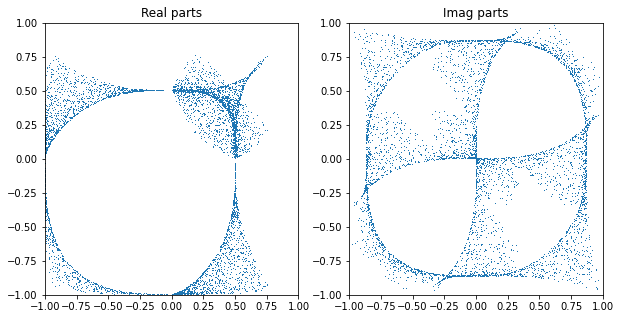

In [8]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.xlim(-1, 1); plt.ylim(-1, 1)
plt.title('Real parts')
plt.plot(zs[:,0].real, zs[:,1].real, ',', color='C0')

plt.subplot(122)
plt.xlim(-1, 1); plt.ylim(-1, 1)
plt.title('Imag parts')
plt.plot(zs[:,0].imag, zs[:,1].imag, ',')

plt.show()

If we interpret the coordinates as lying in another patch and transforming back, we get a slightly fuller picture...

In [9]:
zs_1 = cyjax.change_chart(zs, 1, 0)
zs_2 = cyjax.change_chart(zs, 2, 0)

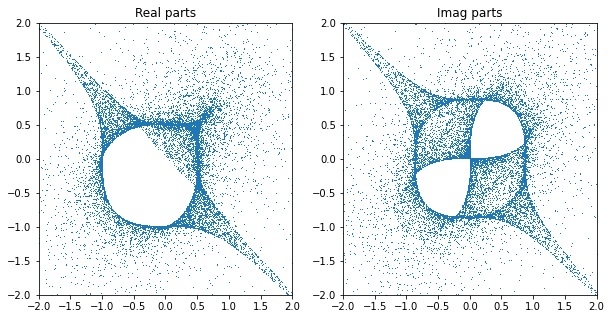

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.xlim(-2, 2); plt.ylim(-2, 2)
plt.title('Real parts')
for pts in [zs, zs_1, zs_2]:
    plt.plot(pts[:,0].real, pts[:,1].real, ',', color='C0')

plt.subplot(122)
plt.xlim(-2, 2); plt.ylim(-2, 2)
plt.title('Imag parts')
for pts in [zs, zs_1, zs_2]:
    plt.plot(pts[:,0].imag, pts[:,1].imag, ',', color='C0')
    
plt.show()

## Chart specific sampling
There is another even more straightforward way of sampling points (for which we don't have a known probabilty density, however). We can simply pick one patch, randomly sample all but one affine coordinates and solve for the last. The main benefit is that we can control the patch size $S$ explicitly, i.e. can generate only samples with $|z_i| < S$. It is also not very difficult to generalise this to only sample points in the overlap of two patches of given size. This may be useful if we need to compute an overlap loss (and want to avoid large numbers).

In [11]:
zs_base = cyjax.random.uniform_angle(next(rns), (2500, 1))  # S = 1
zs = dwork.solve_defining(zs_base, np.array([0]), 0, 0)
zs.shape  # three solutions for each sample point

(2500, 3, 2)

In [12]:
error = jnp.abs(dwork.defining(zs, np.array([0]), 0))
jnp.mean(error)  # average value of defining polynomial for sampled points

DeviceArray(1.2700805e-15, dtype=float64)

In [13]:
zs = zs.reshape((-1, 2))  # could shuffle if independence is important

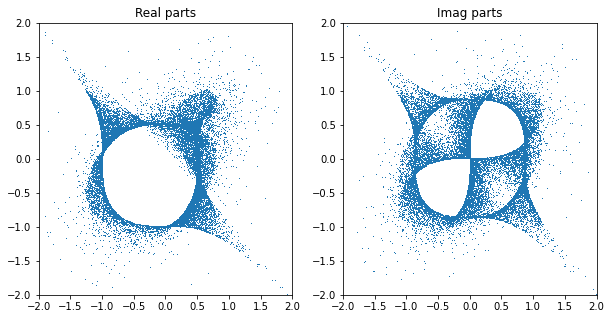

In [14]:
# we can get a qualitative idea of the difference to intersection sampling
zs_1 = cyjax.change_chart(zs, 1, 0)
zs_2 = cyjax.change_chart(zs, 2, 0)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.xlim(-2, 2); plt.ylim(-2, 2)
plt.title('Real parts')
for pts in [zs, zs_1, zs_2]:
    plt.plot(pts[:,0].real, pts[:,1].real, ',', color='C0')

plt.subplot(122)
plt.xlim(-2, 2); plt.ylim(-2, 2)
plt.title('Imag parts')
for pts in [zs, zs_1, zs_2]:
    plt.plot(pts[:,0].imag, pts[:,1].imag, ',', color='C0')
    
plt.show()

The distribution above looks asymmetric. The reason is that the coordinate we solved for is always inserted at the same index (and the initial sampling of coordinates is not uniform with respect to the variety). This breaks the symmetry. We can recover it by shuffling the coordinates.

In [15]:
zs = cyjax.util.shuffle_axis(next(rns), zs, 1)

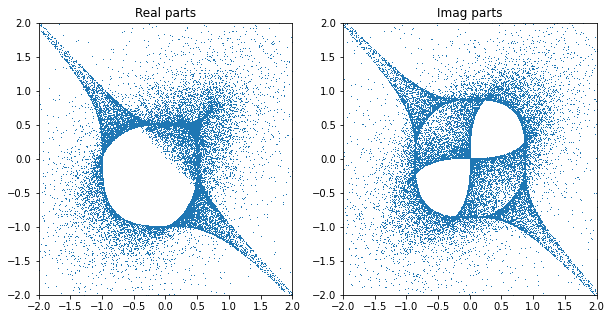

In [16]:
# we can get a qualitative idea of the difference to intersection sampling
zs_1 = cyjax.change_chart(zs, 1, 0)
zs_2 = cyjax.change_chart(zs, 2, 0)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.xlim(-2, 2); plt.ylim(-2, 2)
plt.title('Real parts')
for pts in [zs, zs_1, zs_2]:
    plt.plot(pts[:,0].real, pts[:,1].real, ',', color='C0')

plt.subplot(122)
plt.xlim(-2, 2); plt.ylim(-2, 2)
plt.title('Imag parts')
for pts in [zs, zs_1, zs_2]:
    plt.plot(pts[:,0].imag, pts[:,1].imag, ',', color='C0')
    
plt.show()

# Batched sampler
One constraint is that, at the moment, non-hermitian eigenvalue finding is not supported on the GPU.
That means samples have to be generated using the CPU.
We can thus either:

1. Train & sample on the CPU.
2. Generate and save samples to disk, then train on GPU.
3. Sample on CPU and train on GPU.

For the last purporse, a class `cyjax.ml.BatchSampler` is provided.

In [17]:
variety = cyjax.Dwork(3)

def psi_sampler(key, batch_size):
    return cyjax.random.uniform_angle(key, (batch_size, 1))

sampler = cyjax.ml.BatchSampler(
    seed=next(rns),
    variety=variety,
    params_sampler=psi_sampler,
    batch_size_params=5,  # number of moduli values per sample
    batch_size=50,  # number of z-samples per set of moduli
    buffer_size=5,  # number of samples to keep in buffer
)

In [18]:
sample = next(sampler)
# psi, zs, patch, weights
jax.tree_map(jnp.shape, sample)

((5, 1), (5, 50, 4), (5, 50), (5, 50))